In [0]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/
!tar -xf data/VOCtrainval_06-Nov-2007.tar

URL transformed to HTTPS due to an HSTS policy
--2020-02-03 21:20:29--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘data/VOCtrainval_06-Nov-2007.tar.1’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  18.0MB/s    in 22s     

2020-02-03 21:20:52 (19.6 MB/s) - ‘data/VOCtrainval_06-Nov-2007.tar.1’ saved [460032000/460032000]



In [0]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input,concatenate,Dense,add,MaxPooling2D,Activation,Concatenate, LSTM ,Lambda, Dropout, BatchNormalization , Conv2D , Conv3D , Flatten , GRU , CuDNNGRU , CuDNNLSTM , UpSampling2D
import numpy as np
from keras.models import Model
from keras.applications import vgg16
import keras.backend as K
import tensorflow as tf
import gc
from keras.models import model_from_json
from google.colab.patches import cv2_imshow
import os
%tensorflow_version 1.x

In [0]:
# import glob
# list_of_photos = glob.glob("/content/VOCdevkit/VOC2007/JPEGImages" + '/*.jpg')

In [0]:
def resize_photo(size,list):
  resize_list=[]
  for img in list:
    resize_list.append(cv2.resize(img,(size,size)))
  return resize_list

In [0]:
def load_images_from_folder(folder):
    images = []
    i=0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
    
list_of_photos = load_images_from_folder('/content/VOCdevkit/VOC2007/JPEGImages')

In [0]:
def print_photos(first,sec,third):
  f, axarr = plt.subplots(1,3,figsize = (17,5))
  axarr[0].imshow(first)
  axarr[1].imshow(sec)
  axarr[2].imshow(third)

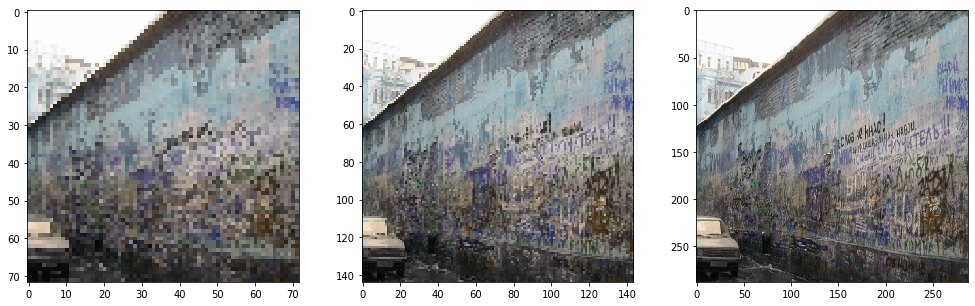

In [0]:

%matplotlib inline
resize_images72=resize_photo(72,list_of_photos)
resize_images144=resize_photo(144,list_of_photos)
resize_images288=resize_photo(288,list_of_photos)
print_photos(resize_images72[0],resize_images144[0],resize_images288[0])

## Train / Val / Test

In [0]:
## train using 72 and 144 pixls photos (index photos : 0-4000)
x_train = np.array(resize_images72[4000:]).astype('float32') /255.
x_train144 = np.array(resize_images144[4000:]).astype('float32') /255.
y_train144 = np.array(resize_images144[4000:]).astype('float32') /255.
y_train288 = np.array(resize_images288[4000:]).astype('float32') /255.

## validation using 72 and 144 pixls photos (index photos : 4000-4500)
x_val= np.array(resize_images72[4000:4500]).astype('float32') /255.
x_val144= np.array(resize_images144[4000:4500]).astype('float32') /255.
y_val144= np.array(resize_images144[4000:4500]).astype('float32') /255.
y_val288= np.array(resize_images288[4000:4500]).astype('float32') /255.

## test using 72 and 144 pixls photos (index photos : 4500-end)
x_test= np.array(resize_images72[4500:len(resize_images72)]).astype('float32') /255.
y_test144= np.array(resize_images144[4500:len(resize_images72)]).astype('float32') /255.
y_test288= np.array(resize_images288[4500:len(resize_images72)]).astype('float32') /255.

In [0]:
def res_block():
  inp = Input(shape=(None,None,64))
  x=Conv2D(64,(3,3),padding="same", activation="relu")(inp)
  x=Conv2D(64,(3,3),padding="same", activation="relu")(x)
  x=add([x,inp])
  X=Activation('relu')(x)
  return Model(inp,x)

# Model 1

In [0]:
model1 = Sequential()
model1.add(Conv2D(input_shape=(resize_images72[0].shape),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
model1.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", activation="relu"))
model1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model1.summary()
model1.fit(x_train,y_train144,batch_size = 32,epochs = 10,validation_data=(x_val,y_val144),verbose=1,shuffle=False)






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 144, 144, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 144, 144, 3)       195       
Total params: 38,915
Trainable params: 38,915
Non-trainable params: 0
_________________________________________________________________



Train on 1011 samples, validate on 500 samples
Epoch 1/10





1011/1011 [==============================] - 15s 15ms/step - loss: 0.0386 - acc: 0.4934 - val_loss: 0.0115 - val_acc: 0.5611
Epoch 2/10
1011/1011 [==============================

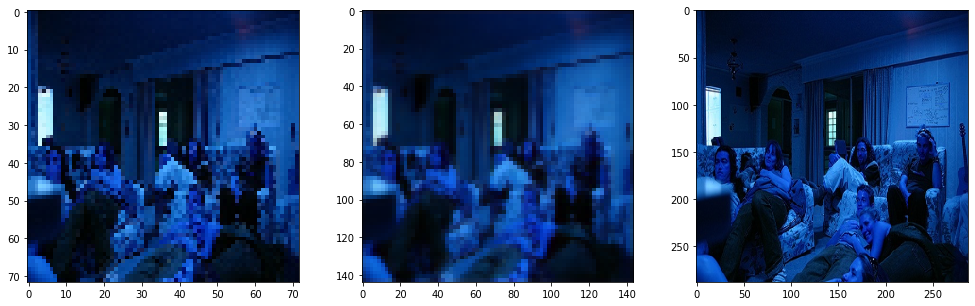

In [0]:
pred_new_res=model1.predict(x_test,batch_size=32)
print_photos(x_test[0],pred_new_res[0],resize_images288[4500])

# Model 2

In [0]:
inputs72 = Input(shape=(resize_images72[0].shape))
x=Conv2D(64,kernel_size=(3,3),padding="same", activation="relu")(inputs72)
x=Conv2D(64,kernel_size=(3,3),padding="same", activation="relu")(x)
x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
output_72=Conv2D(3,kernel_size=(1,1),padding="same", activation="relu")(x)

x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)

output_144 = Conv2D(3,kernel_size=(1,1),padding="same", activation="relu")(x)

# a layer instance is callable on a tensor, and returns a tensor
model2 = Model(inputs=inputs72, outputs=[output_72,output_144])
model2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model2.summary()
model2.fit(x_train,[y_train144,y_train288],batch_size = 32,epochs = 10,validation_data=(x_val,[y_val144,y_val288]),verbose=1,shuffle=False)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 72, 72, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 72, 72, 64)   36928       conv2d_8[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 144, 144, 64) 0           conv2d_9[0][0]                   
____________________________________________________________________________________________

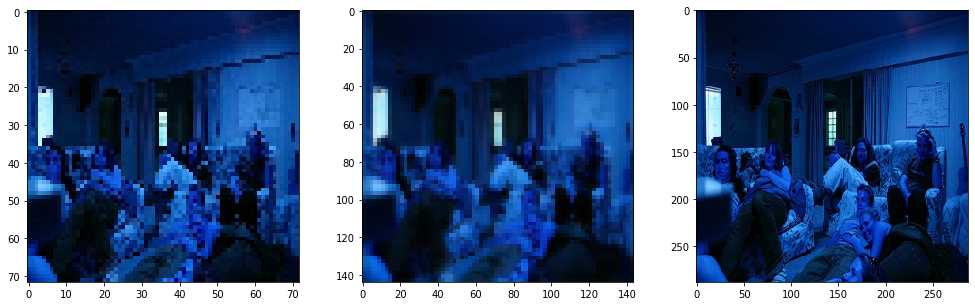

In [0]:
pred_new_res2=model2.predict(x_test,batch_size=32)
print_photos(x_test[0],pred_new_res2[0][0],resize_images288[4500])

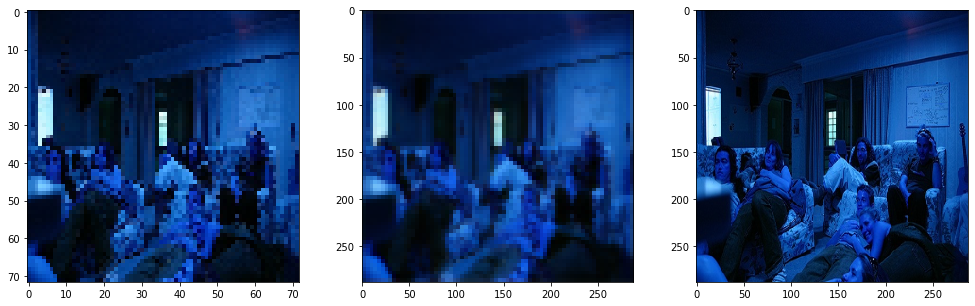

In [0]:
pred_new_res2_288=model2.predict(x_test,batch_size=32)
print_photos(x_test[0],pred_new_res2_288[1][0],resize_images288[4500])

## Model 3

In [0]:
inputs72 = Input(shape=(resize_images72[0].shape))
x=Conv2D(64,kernel_size=(3,3),padding="same", activation="relu")(inputs72)
x=res_block()(x)
x=res_block()(x)
x=res_block()(x)
x=res_block()(x)
x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
output_72=Conv2D(3,kernel_size=(1,1),padding="same", activation="relu")(x)
x=res_block()(x)
x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)

output_144 = Conv2D(3,kernel_size=(1,1),padding="same", activation="relu")(x)

model_3 = Model(inputs=inputs72, outputs=[output_72,output_144])

model_3.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_3.summary()

model_3.fit(x_train,[y_train144,y_train288],batch_size = 32,epochs = 10,validation_data=(x_val,[y_val144,y_val288]),verbose=1,shuffle=False)

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 72, 72, 64)   1792        input_15[0][0]                   
__________________________________________________________________________________________________
model_15 (Model)                multiple             73856       conv2d_38[0][0]                  
__________________________________________________________________________________________________
model_16 (Model)                multiple             73856       model_15[1][0]                   
___________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


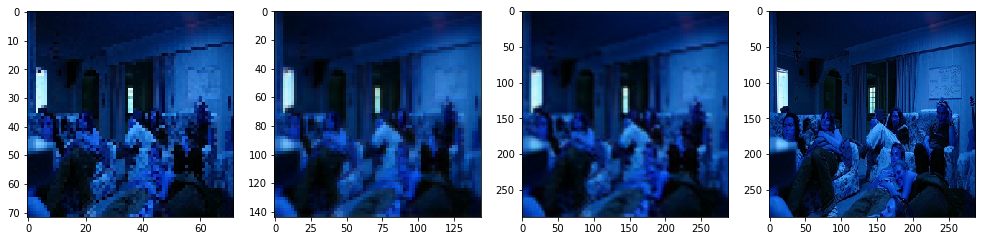

In [0]:
pred_new_res3_288=model_3.predict(x_test,batch_size=32)
f, axarr = plt.subplots(1,4,figsize = (17,5))
axarr[0].imshow(x_test[0])
axarr[1].imshow(pred_new_res3_288[0][0])
axarr[2].imshow(pred_new_res3_288[1][0])
axarr[3].imshow(resize_images288[4500])


## Model 4

In [0]:
inputs = Input(shape=(resize_images72[0].shape))
x=Conv2D(64,kernel_size=(1,1),padding="same", activation="relu")(inputs)
x1=res_block()(x)

x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None)(x1)

x2 = res_block()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None)(x2)

x_up1=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)

x=res_block()(x_up1)
x_up2=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)

x3=res_block()(x_up2)
x_up3=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x3)

output=Conv2D(3,kernel_size=(1,1),padding="same", activation="relu")(x_up3)

x = add([x1,x_up2])
x = add([x2,x_up1])

model_4 = Model(inputs=inputs, outputs=output)

model_4.summary()

model_4.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_4.fit(x=x_train,y=y_train144,batch_size=32,epochs=20,validation_data=(x_val,y_val144),verbose=1)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 72, 72, 3)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 72, 72, 64)        256       
_________________________________________________________________
model_26 (Model)             multiple                  73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
model_27 (Model)             multiple                  73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 36, 36, 64)        0  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


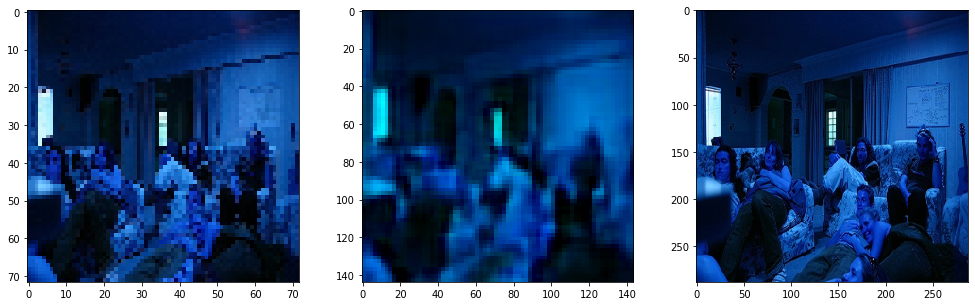

In [0]:
pred_new_res=model_4.predict(x_test,batch_size=32)
print_photos(x_test[0],pred_new_res[0],resize_images288[4500])
# f, axarr = plt.subplots(1,3,figsize = (17,5))
# axarr[0].imshow(x_test[0])
# axarr[1].imshow(pred_new_res[0])
# axarr[2].imshow(resize_images288[4500])

# model - using vgg16

In [0]:
from keras.applications.vgg16 import VGG16
def vgg_input(currentInput):
  vgg16 = VGG16(weights='imagenet', include_top=False ,input_shape=((72,72,3)))
  vgg16.summary()
  x = vgg16.layers[0](currentInput)
  x = Conv2D(filters = 64, kernel_size = 1)(x)
  x = vgg16.layers[2](x)
  x = concatenate([currentInput,x],axis=3)
  return x

In [0]:
inp = Input(shape = (72,72,3))
input_vgg = vgg_input(inp)
x = Conv2D(filters = 64, kernel_size = 1)(input_vgg)
x = Conv2D(filters = 64, kernel_size = 1)(x)
x = res_block()(x)
x = UpSampling2D()(x)
output_mid = Conv2D(filters = 3, kernel_size = 1)(x)
x = res_block()(x)
x = UpSampling2D()(x)
output_large = Conv2D(filters = 3, kernel_size = 1)(x)

m_large = Model(inputs = inp , outputs = [output_mid, output_large])
m_large.compile(loss='mse', optimizer ='adam',metrics=['accuracy'])


58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 72, 72, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
______________________________________________________________

In [0]:
m_large.fit(x=x_train,y=[y_train144,y_train288],batch_size=32,epochs=200,validation_data=(x_val,[y_val144,y_val288]),verbose=1)

Train on 1011 samples, validate on 500 samples
Epoch 1/200
1011/1011 [==============================] - 7s 6ms/step - loss: 0.0767 - conv2d_76_loss: 0.0247 - conv2d_79_loss: 0.0519 - conv2d_76_acc: 0.5427 - conv2d_79_acc: 0.5539 - val_loss: 0.0182 - val_conv2d_76_loss: 0.0093 - val_conv2d_79_loss: 0.0089 - val_conv2d_76_acc: 0.6918 - val_conv2d_79_acc: 0.7100
Epoch 2/200
1011/1011 [==============================] - 5s 5ms/step - loss: 0.0167 - conv2d_76_loss: 0.0086 - conv2d_79_loss: 0.0080 - conv2d_76_acc: 0.6939 - conv2d_79_acc: 0.7458 - val_loss: 0.0154 - val_conv2d_76_loss: 0.0080 - val_conv2d_79_loss: 0.0074 - val_conv2d_76_acc: 0.7469 - val_conv2d_79_acc: 0.7575
Epoch 3/200
1011/1011 [==============================] - 5s 5ms/step - loss: 0.0151 - conv2d_76_loss: 0.0078 - conv2d_79_loss: 0.0072 - conv2d_76_acc: 0.7633 - conv2d_79_acc: 0.7789 - val_loss: 0.0146 - val_conv2d_76_loss: 0.0076 - val_conv2d_79_loss: 0.0070 - val_conv2d_76_acc: 0.7765 - val_conv2d_79_acc: 0.7938
Epoch 4/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


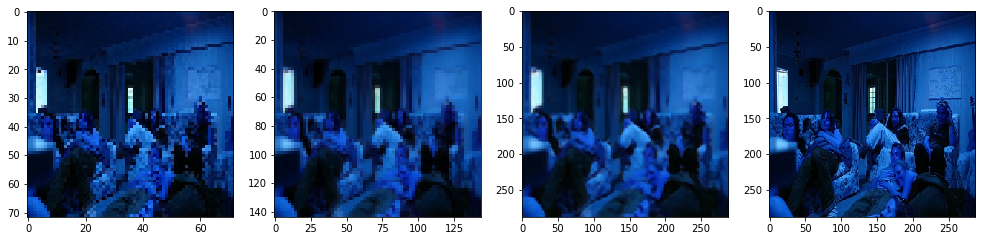

In [0]:
m_large_288=m_large.predict(x_test,batch_size=32)
f, axarr = plt.subplots(1,4,figsize = (17,5))
axarr[0].imshow(x_test[0])
axarr[1].imshow(m_large_288[0][0])
axarr[2].imshow(m_large_288[1][0])
axarr[3].imshow(resize_images288[4500])

In [0]:
def dil_block():
  inp = Input(shape=(None,None,32))
  x1=Conv2D(32,(3,3),dilation_rate=1,padding="same", activation="relu")(inp)
  x2=Conv2D(32,(3,3),dilation_rate=2,padding="same", activation="relu")(inp)
  x3=Conv2D(32,(3,3),dilation_rate=4,padding="same", activation="relu")(inp)
  x=Concatenate()([x1,x2,x3])
  x=Conv2D(32,(1,1),padding="same", activation="relu")(x)
  x=add([x,inp])
  x=Activation('relu')(x)
  return Model(inp,x)

## Model - residual block dilation 

In [0]:
inputs72 = Input(shape=(resize_images72[0].shape))
x=Conv2D(32,(1,1), activation="relu")(inputs72)
x=dil_block()(x)
x=dil_block()(x)
x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
output_72=Conv2D(3,kernel_size=(1,1),padding="same", activation="relu")(x)
x=dil_block()(x)
x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
output_144 = Conv2D(3,kernel_size=(1,1),padding="same", activation="relu")(x)
model_res_block_dilation = Model(inputs=inputs72, outputs=[output_72,output_144])
model_res_block_dilation.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_res_block_dilation.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 72, 72, 32)   128         input_35[0][0]                   
__________________________________________________________________________________________________
model_34 (Model)                multiple             30848       conv2d_80[0][0]                  
__________________________________________________________________________________________________
model_35 (Model)                multiple             30848       model_34[1][0]                   
___________________________________________________________________________________________

In [0]:
model_res_block_dilation.fit(x_train,[y_train144,y_train288],batch_size = 32,epochs = 10,validation_data=(x_val,[y_val144,y_val288]),verbose=1,shuffle=False)

Train on 1011 samples, validate on 500 samples
Epoch 1/10
1011/1011 [==============================] - 8s 8ms/step - loss: 0.1146 - conv2d_89_loss: 0.0613 - conv2d_94_loss: 0.0533 - conv2d_89_acc: 0.5015 - conv2d_94_acc: 0.4316 - val_loss: 0.0244 - val_conv2d_89_loss: 0.0122 - val_conv2d_94_loss: 0.0122 - val_conv2d_89_acc: 0.5638 - val_conv2d_94_acc: 0.6064
Epoch 2/10
1011/1011 [==============================] - 5s 5ms/step - loss: 0.0200 - conv2d_89_loss: 0.0103 - conv2d_94_loss: 0.0097 - conv2d_89_acc: 0.6530 - conv2d_94_acc: 0.6562 - val_loss: 0.0175 - val_conv2d_89_loss: 0.0089 - val_conv2d_94_loss: 0.0086 - val_conv2d_89_acc: 0.6717 - val_conv2d_94_acc: 0.6954
Epoch 3/10
1011/1011 [==============================] - 5s 5ms/step - loss: 0.0169 - conv2d_89_loss: 0.0086 - conv2d_94_loss: 0.0083 - conv2d_89_acc: 0.7012 - conv2d_94_acc: 0.6901 - val_loss: 0.0163 - val_conv2d_89_loss: 0.0083 - val_conv2d_94_loss: 0.0079 - val_conv2d_89_acc: 0.6918 - val_conv2d_94_acc: 0.7181
Epoch 4/10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


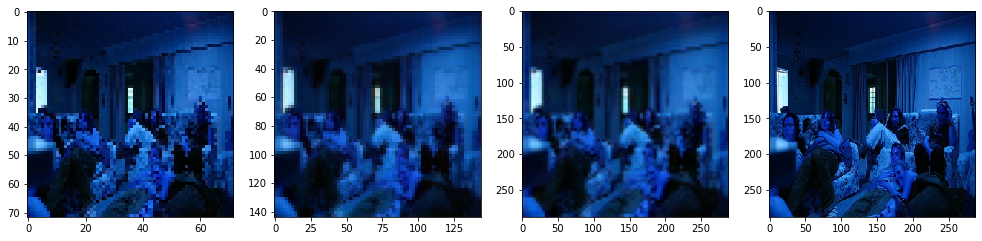

In [0]:
pred_model_res_block_dilation=model_res_block_dilation.predict(x_test,batch_size=32)
f, axarr = plt.subplots(1,4,figsize = (17,5))
axarr[0].imshow(x_test[0])
axarr[1].imshow(pred_model_res_block_dilation[0][0])
axarr[2].imshow(pred_model_res_block_dilation[1][0])
axarr[3].imshow(resize_images288[4500])


In [0]:
from keras.layers import LeakyReLU

class LeakyRELU(LeakyReLU):
  def __init__(self, **kwargs):
    self.__name__="LeakyReLU"
    super(LeakyRELU,self).__init__(**kwargs)

In [0]:
def dil_block_NEW():
  inp = Input(shape=(None,None,32))
  x1=Conv2D(32,(3,3),dilation_rate=1,padding="same")(inp)
  x=Activation(LeakyRELU(alpha = 0.2))(x1)
  x2=Conv2D(32,(3,3),dilation_rate=2,padding="same")(inp)
  x=Activation(LeakyRELU(alpha = 0.2))(x2)
  x3=Conv2D(32,(3,3),dilation_rate=4,padding="same")(inp)
  x=Activation(LeakyRELU(alpha = 0.2))(x3)
  x=Concatenate()([x1,x2,x3])
  x=Conv2D(32,(1,1),padding="same")(x)
  x=Activation(LeakyRELU(alpha = 0.2))(x)
  x=add([x,inp])
  x=Activation(LeakyRELU(alpha = 0.2))(x)
  return Model(inp,x)

In [0]:
inputs72 = Input(shape=(resize_images72[0].shape))
x=Conv2D(32,(1,1))(inputs72)
x=Activation(LeakyRELU(alpha = 0.2))(x)
x=dil_block()(x)
x=dil_block()(x)
x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
output_72=Conv2D(3,kernel_size=(1,1),padding="same")(x)
x=Activation(LeakyRELU(alpha = 0.2))(x)
x=dil_block()(x)
x=UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')(x)
output_144 = Conv2D(3,kernel_size=(1,1),padding="same")(x)
x=Activation(LeakyRELU(alpha = 0.2))(x)
model_6 = Model(inputs=inputs72, outputs=[output_72,output_144])
model_6.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_6.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyRELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 72, 72, 32)   128         input_39[0][0]                   
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 72, 72, 32)   0           conv2d_95[0][0]                  
__________________________________________________________________________________________________
model_38 (Model)                multiple             30848       activation_29[0][0]              
___________________________________________________________________________________________

In [0]:
model_6.fit(x_train,[y_train144,y_train288],batch_size = 32,epochs = 5,validation_data=(x_val,[y_val144,y_val288]),verbose=1,shuffle=False)

Train on 1011 samples, validate on 500 samples
Epoch 1/5
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0838 - conv2d_104_loss: 0.0532 - conv2d_109_loss: 0.0305 - conv2d_104_acc: 0.4580 - conv2d_109_acc: 0.5137 - val_loss: 0.0220 - val_conv2d_104_loss: 0.0119 - val_conv2d_109_loss: 0.0101 - val_conv2d_104_acc: 0.5477 - val_conv2d_109_acc: 0.5946
Epoch 2/5
1011/1011 [==============================] - 5s 5ms/step - loss: 0.0196 - conv2d_104_loss: 0.0107 - conv2d_109_loss: 0.0089 - conv2d_104_acc: 0.5865 - conv2d_109_acc: 0.6589 - val_loss: 0.0177 - val_conv2d_104_loss: 0.0095 - val_conv2d_109_loss: 0.0082 - val_conv2d_104_acc: 0.5963 - val_conv2d_109_acc: 0.6901
Epoch 3/5
1011/1011 [==============================] - 5s 5ms/step - loss: 0.0168 - conv2d_104_loss: 0.0089 - conv2d_109_loss: 0.0079 - conv2d_104_acc: 0.6560 - conv2d_109_acc: 0.7306 - val_loss: 0.0160 - val_conv2d_104_loss: 0.0084 - val_conv2d_109_loss: 0.0076 - val_conv2d_104_acc: 0.7028 - val_conv2d_109_ac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


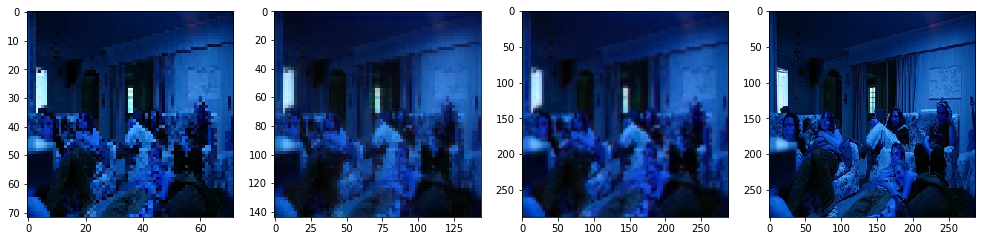

In [0]:
pred_new_res3_288=model_6.predict(x_test,batch_size=32)
f, axarr = plt.subplots(1,4,figsize = (17,5))
axarr[0].imshow(x_test[0])
axarr[1].imshow(pred_new_res3_288[0][0])
axarr[2].imshow(pred_new_res3_288[1][0])
axarr[3].imshow(resize_images288[4500])


In [0]:
def get_dilated_res_conv_block():
  inp = Input(shape=(None,None,32))
  x1=Conv2D(32,(3,3),dilation_rate=1,padding="same")(inp)
  x=Activation(LeakyRELU(alpha = 0.2))(x1)
  x2=Conv2D(32,(3,3),dilation_rate=2,padding="same")(inp)
  x=Activation(LeakyRELU(alpha = 0.2))(x2)
  x3=Conv2D(32,(3,3),dilation_rate=4,padding="same")(inp)
  x=Activation(LeakyRELU(alpha = 0.2))(x3)
  x=Concatenate()([x1,x2,x3])
  x=Conv2D(32,(1,1),padding="same")(x)
  x=Activation(LeakyRELU(alpha = 0.2))(x)
  x=add([x,inp])
  x=Activation(LeakyRELU(alpha = 0.2))(x)
  return Model(inp,x)

In [0]:
inp = Input(shape=(72, 72, 3))
x = Conv2D(32, kernel_size=(3, 3), padding='same', activation=LeakyRELU(alpha=0.2))(inp)
x = get_dilated_res_conv_block()(x)
x = get_dilated_res_conv_block()(x)
x = get_dilated_res_conv_block()(x)
x = get_dilated_res_conv_block()(x)
x = get_dilated_res_conv_block()(x)
x = Lambda(lambda t: tf.depth_to_space(x, block_size=2))(x)
y1 = Conv2D(3,3,padding='same', activation=LeakyRELU(alpha=0.2))(x)
x = Conv2D(32, kernel_size=(3, 3),padding='same', activation=LeakyRELU(alpha=0.2))(y1)
x = get_dilated_res_conv_block()(x)
x = get_dilated_res_conv_block()(x)
x = Lambda(lambda t: tf.depth_to_space(x, block_size=2))(x)
output = Conv2D(3,3,padding='same', activation=LeakyRELU(alpha=0.2))(x)
model_7 = Model(inputs=inp, outputs=[output])
model_7.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_7.summary()
# return Model(inp, y1)

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyRELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_96 (InputLayer)        (None, 72, 72, 3)         0         
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 72, 72, 32)        896       
_________________________________________________________________
model_90 (Model)             multiple                  30848     
_________________________________________________________________
model_91 (Model)             multiple                  30848     
_________________________________________________________________
model_92 (Model)             multiple                  30848     
_________________________________________________________________
model_93 (Model)             multiple                  30848     
_________________________________________________________________
model_94 (Model)             multiple                  308

In [0]:
model_7.fit(x_train,y_train288,batch_size = 32,epochs = 50,verbose=1,shuffle=False)

Epoch 1/50
1011/1011 [==============================] - 12s 12ms/step - loss: 0.0938 - acc: 0.3098
Epoch 2/50
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0195 - acc: 0.3983
Epoch 3/50
1011/1011 [==============================] - 7s 6ms/step - loss: 0.0155 - acc: 0.4364
Epoch 4/50
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0132 - acc: 0.5088
Epoch 5/50
1011/1011 [==============================] - 7s 6ms/step - loss: 0.0112 - acc: 0.5427
Epoch 6/50
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0102 - acc: 0.5936
Epoch 7/50
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0092 - acc: 0.6242
Epoch 8/50
1011/1011 [==============================] - 7s 6ms/step - loss: 0.0089 - acc: 0.6274
Epoch 9/50
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0086 - acc: 0.6345
Epoch 10/50
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0084 - acc: 0.6416
Epoch 11/50
1011/1011 [====

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


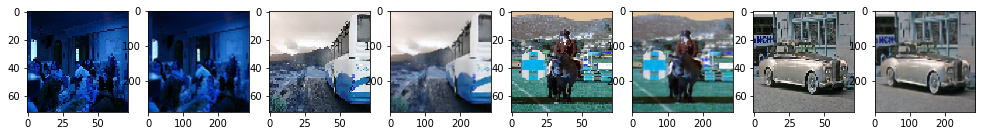

In [0]:
pred_d2=model_7.predict(x_test,batch_size=32)
f, axarr = plt.subplots(1,8,figsize = (17,5))
axarr[0].imshow(x_test[0])
axarr[1].imshow(pred_d2[0])
axarr[2].imshow(x_test[500])
axarr[3].imshow(pred_d2[500])
axarr[4].imshow(x_test[499])
axarr[5].imshow(pred_d2[499])
axarr[6].imshow(x_test[498])
axarr[7].imshow(pred_d2[498])